# Loading Part 3: Lake

In this example, we explore the process of working with data from multiple instruments and consolidating them into a single `Lake` object. A `Lake` object serves as a convenient container for aggregating multiple `Stream`s, each representing data from individual instruments.

## Setting the Working Path

To begin, you need to establish the working path where your data is stored. For this demonstration, we will use provided example data located in the current directory. However, keep in mind that the path can be anywhere on your computer. For instance, if you have a folder named "data" in your home directory, you can set the path as follows:

```python
path = "U:\\data\\processing\\Campaign2023_of_awesome\\data"
```

Your folder structure should resemble the following:

```
data
├── CPC_3010_data
│   ├── CPC_3010_data_20220709_Jul.csv
│   ├── CPC_3010_data_20220709_Jul.csv
├── SMPS_data
│   ├── 2022-07-07_095151_SMPS.csv
│   ├── 2022-07-10_094659_SMPS.csv
```

Here, the path points to the "data" folder. Within this folder, you'll find two subfolders: one for CPC data and another for SMPS data. These subfolders correspond to the relative_data_folder keywords used in the settings dictionary. The data within these subfolders will be loaded as Stream objects.

Inside each of these subfolders, you'll find data files that match the specified filename_regex. A regular expression is used to select files based on specific criteria. In this case, we are matching all files ending with ".csv" and loading them into the respective Stream objects. This approach allows you to efficiently manage and consolidate data from various instruments for further analysis and visualization.

In [12]:
# Import necessary modules
import os  # Provides functions for interacting with the operating system.
# Matplotlib is a library for creating visualizations and plots.
import matplotlib.pyplot as plt
from particula.data import (
    loader_interface,  # This module allows you to load data from files.
    # This module provides statistics for a collection of data streams.
    lake_stats
)
from particula.data.loader_setting_builders import (
    # These functions create settings for loading data from files.
    DataChecksBuilder,
    SizerDataReaderBuilder,
    Loader1DSettingsBuilder,
    LoaderSizerSettingsBuilder
)
from particula.data.tests.example_data.get_example_data import get_data_folder
# Lake is a container for multiple data streams.
from particula.data.lake import Lake

# Set the parent directory of the data folder
path = get_data_folder()

## Load the Data

In this example, we'll work with provided example data. However, you have the flexibility to change the path to any folder on your computer. We will use the settings generator to efficiently load the data.



In [13]:
# settings for the CPC data
data_checks_cpc = (
    DataChecksBuilder()
    .set_characters([10, 100])
    .set_char_counts({",": 4})
    .set_skip_rows(0)
    .set_skip_end(0)
    .build()
)

cpc_settings = (
    Loader1DSettingsBuilder()
    .set_relative_data_folder("CPC_3010_data")
    .set_filename_regex("*.csv")
    .set_header_row(0)
    .set_data_checks(data_checks_cpc)  # from above
    .set_data_column([1, 2])
    .set_data_header(["CPC_count[#/sec]", "Temperature[degC]"])
    .set_time_column([0])
    .set_time_format("epoch")
    .set_delimiter(",")
    .set_timezone_identifier("UTC")
    .build()
)

# settings for the SMPS data
data_checks_sizer = (
    DataChecksBuilder()
    .set_characters([250])
    .set_skip_rows(25)
    .set_char_counts({"/": 2, ":": 2})
    .build()
)
data_sizer_reader = (
    SizerDataReaderBuilder()
    .set_sizer_start_keyword("20.72")
    .set_sizer_end_keyword("784.39")
    .set_sizer_concentration_convert_from("dw/dlogdp")
    .build()
)
smps_1d_settings, smps_2d_settings = (
    LoaderSizerSettingsBuilder()
    .set_relative_data_folder("SMPS_data")
    .set_filename_regex("*.csv")
    .set_header_row(24)
    .set_data_checks(data_checks_sizer)
    .set_data_column(
        [
            "Lower Size (nm)",
            "Upper Size (nm)",
            "Sample Temp (C)",
            "Sample Pressure (kPa)",
            "Relative Humidity (%)",
            "Median (nm)",
            "Mean (nm)",
            "Geo. Mean (nm)",
            "Mode (nm)",
            "Geo. Std. Dev.",
            "Total Conc. (#/cm³)",
        ]
    )
    .set_data_header(
        [
            "Lower_Size_(nm)",
            "Upper_Size_(nm)",
            "Sample_Temp_(C)",
            "Sample_Pressure_(kPa)",
            "Relative_Humidity_(%)",
            "Median_(nm)",
            "Mean_(nm)",
            "Geo_Mean_(nm)",
            "Mode_(nm)",
            "Geo_Std_Dev.",
            "Total_Conc_(#/cc)",
        ]
    )
    .set_data_sizer_reader(data_sizer_reader)
    .set_time_column([1, 2])
    .set_time_format("%m/%d/%Y %H:%M:%S")
    .set_delimiter(",")
    .set_timezone_identifier("UTC")
    .build()
)

# collect settings into a dictionary
combined_settings = {
    'cpc': cpc_settings,
    'smps_1d': smps_1d_settings,
    'smps_2d': smps_2d_settings,
}

# now call the loader interface for files
lake = loader_interface.load_folders_interface(
    path=path,
    folder_settings=combined_settings,
)

print(' ')
print(lake)

Folder Settings: cpc
  Loading file: CPC_3010_data_20220709_Jul.csv
  Loading file: CPC_3010_data_20220710_Jul.csv
Folder Settings: smps_1d
  Loading file: 2022-07-07_095151_SMPS.csv
  Loading file: 2022-07-10_094659_SMPS.csv
Folder Settings: smps_2d
  Loading file: 2022-07-07_095151_SMPS.csv
  Loading file: 2022-07-10_094659_SMPS.csv
 
Lake with streams: ['cpc', 'smps_1d', 'smps_2d']


## Lake Class Overview

The `Lake` is a collection of `Stream` objects stored as a dictionary. The keys represent the names of the streams, and the values are the stream objects themselves. It provides a convenient way to organize and manage multiple datasets. Let's explore its key attributes and methods:

### Attributes:
- `streams` (Dict[str, Stream]): A dictionary where keys are stream names, and values are the corresponding `Stream` objects.

### Methods:
- `__getitem__(self, key: str) -> Any`: Retrieve a specific `Stream` by its name.
  - Example: To access the CPC stream, you can use `lake['cpc']`.

- `__delitem__(self, key: str) -> None`: Remove a `Stream` from the `Lake` using its name.
  - Example: To remove a stream named 'cpc', you can use `del lake['cpc']`.

- `__getattr__(self, name: str) -> Any`: Access streams as attributes for easier navigation.
  - Example: You can directly access the 'cpc' stream with `lake.cpc`.

- `add_stream(self, stream: particula.data.stream.Stream, name: str) -> None`: Add a new `Stream` to the `Lake`.
  - Example: To add a new stream, you can use `lake.add_stream(new_stream, 'stream_name')`.

- `__len__(self) -> int`: Determine the number of streams in the `Lake`.
  - Example: To find out how many streams are in the `Lake`, use `len(lake)`.

- `__iter__(self) -> Iterator[Any]`: Iterate over the streams in the `Lake`.
  - Example: To loop through all streams, you can use `[stream.header for stream in lake]`.

- `summary` (Readonly property): Generate a summary by iterating through each stream and printing their headers.
  - Example: To get a summary of all streams, use `lake.summary`.

### Usage:
The `Lake` class simplifies the management of multiple datasets. You can access individual streams by name, add new streams, and iterate through them efficiently. This class is particularly helpful when dealing with various data sources within your analysis.

In [14]:
# get the names of the streams
print(' ')
print('Names of the streams:')
print(dir(lake))

 
Names of the streams:
['cpc', 'smps_1d', 'smps_2d']


In [15]:
# get the streams
print(' ')
print('The streams:')
for stream in lake:
    print(stream)

 
The streams:
('cpc', Stream(header=['CPC_count[#/sec]', 'Temperature[degC]'], data=array([[3.3510e+04, 1.7000e+01],
       [3.3465e+04, 1.7100e+01],
       [3.2171e+04, 1.7000e+01],
       ...,
       [1.9403e+04, 1.6900e+01],
       [2.0230e+04, 1.7000e+01],
       [1.9521e+04, 1.6800e+01]]), time=array([1.65734280e+09, 1.65734281e+09, 1.65734281e+09, ...,
       1.65751559e+09, 1.65751560e+09, 1.65751560e+09]), files=[['CPC_3010_data_20220709_Jul.csv', 1044534], ['CPC_3010_data_20220710_Jul.csv', 1113488]]))
('smps_1d', Stream(header=['Lower_Size_(nm)', 'Upper_Size_(nm)', 'Sample_Temp_(C)', 'Sample_Pressure_(kPa)', 'Relative_Humidity_(%)', 'Median_(nm)', 'Mean_(nm)', 'Geo_Mean_(nm)', 'Mode_(nm)', 'Geo_Std_Dev.', 'Total_Conc_(#/cc)'], data=array([[2.05000e+01, 7.91500e+02, 2.37000e+01, ..., 2.07210e+01,
        2.17900e+00, 2.16900e+03],
       [2.05000e+01, 7.91500e+02, 2.36000e+01, ..., 2.52550e+01,
        2.10100e+00, 2.39408e+03],
       [2.05000e+01, 7.91500e+02, 2.37000e+01, 

In [16]:
# get just the keys
print(' ')
print('The keys:')
for key in lake.keys():
    print(key)

 
The keys:
cpc
smps_1d
smps_2d


In [17]:
# get just the values
print(' ')
print('The values:')
for value in lake.values():
    print(value)

 
The values:
Stream(header=['CPC_count[#/sec]', 'Temperature[degC]'], data=array([[3.3510e+04, 1.7000e+01],
       [3.3465e+04, 1.7100e+01],
       [3.2171e+04, 1.7000e+01],
       ...,
       [1.9403e+04, 1.6900e+01],
       [2.0230e+04, 1.7000e+01],
       [1.9521e+04, 1.6800e+01]]), time=array([1.65734280e+09, 1.65734281e+09, 1.65734281e+09, ...,
       1.65751559e+09, 1.65751560e+09, 1.65751560e+09]), files=[['CPC_3010_data_20220709_Jul.csv', 1044534], ['CPC_3010_data_20220710_Jul.csv', 1113488]])
Stream(header=['Lower_Size_(nm)', 'Upper_Size_(nm)', 'Sample_Temp_(C)', 'Sample_Pressure_(kPa)', 'Relative_Humidity_(%)', 'Median_(nm)', 'Mean_(nm)', 'Geo_Mean_(nm)', 'Mode_(nm)', 'Geo_Std_Dev.', 'Total_Conc_(#/cc)'], data=array([[2.05000e+01, 7.91500e+02, 2.37000e+01, ..., 2.07210e+01,
        2.17900e+00, 2.16900e+03],
       [2.05000e+01, 7.91500e+02, 2.36000e+01, ..., 2.52550e+01,
        2.10100e+00, 2.39408e+03],
       [2.05000e+01, 7.91500e+02, 2.37000e+01, ..., 2.18700e+01,
    

 # Pause to Plot the data

In this code snippet, we retrieve data from the Lake object and create a dual-axis plot to visualize both CPC and SMPS data over time.

- We access the CPC data from the Lake using lake['cpc']. We retrieve the datetime and CPC count data.
- Similarly, we access the SMPS data from the Lake using lake['smps_1d'] and retrieve the datetime and Mode data.
- We create a plot with a blue line for CPC data using ax.plot(), and an orange line for SMPS data on a twin y-axis axb.
- To improve readability, we rotate the x-axis labels using plt.xticks(rotation=45).
- We set y-axis limits for the SMPS data to be in the range [0, 200] using axb.set_ylim(0, 200).
- Axis labels and legends are added for both datasets.
- Finally, we display the plot and adjust the layout for better visualization using plt.show() and fig.tight_layout().

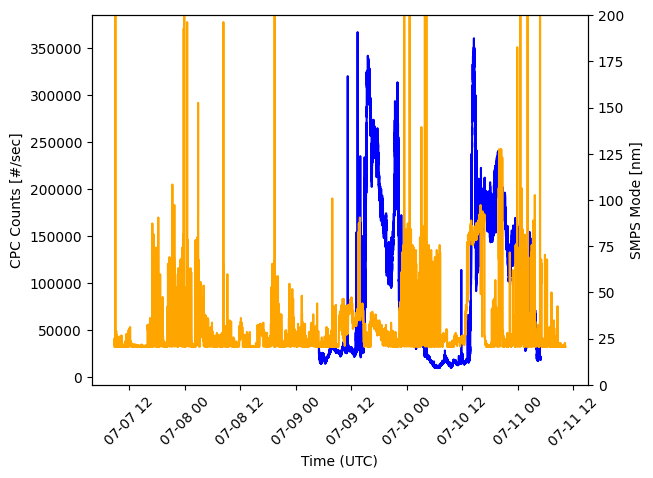

In [18]:
# Load and Plot Data from Lake

# Access CPC data from the Lake
cpc_time = lake['cpc'].datetime64
cpc_data = lake['cpc']['CPC_count[#/sec]']

# Access SMPS data from the Lake
smps_time = lake['smps_1d'].datetime64
smps_data = lake['smps_1d']['Mode_(nm)']

# Plot the Data on Twinx Axis
fig, ax = plt.subplots()

# Plot CPC data
ax.plot(cpc_time,
        cpc_data,
        label='CPC',
        color='blue')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Create a twin y-axis for SMPS data
axb = ax.twinx()

# Plot SMPS data
axb.plot(smps_time,
         smps_data,
         label='SMPS',
         color='orange')

# Set y-axis limits for SMPS data
axb.set_ylim(0, 200)

# Set axis labels
ax.set_xlabel("Time (UTC)")
ax.set_ylabel('CPC Counts [#/sec]')
axb.set_ylabel('SMPS Mode [nm]')

# Display the legend and show the plot
plt.show()

# Adjust layout for better visualization
fig.tight_layout()

## Data Averaging

Now that we have loaded the data, we can perform data averaging over time. To achieve this, we will utilize the 'particula.data.lake_stats' module, which provides a convenient function called 'averaged_std.' This function takes a stream object as input and returns a new stream object containing both the averaged data and the standard deviation of the data.

It's worth noting that this function follows a similar naming convention to 'stream_stats.average_std,' which operates on individual stream objects.

In [19]:
# Compute the average and standard deviation of data within a time interval
# of 600 seconds for each stream in the lake, and create a new lake
# containing the averaged data.
lake_averaged = lake_stats.average_std(
    lake=lake,
    average_interval=600,
    clone=True  # Create a new lake instead of modifying the original
)

# Print the resulting lake with averaged data and standard deviation.
print(lake_averaged)

Lake with streams: ['cpc', 'smps_1d', 'smps_2d']


 # Plot the Averaged Data

Let's plot the averaged data to see how it compares to the raw data. We will use the same approach as before, but this time we will use the averaged data from the Lake object.

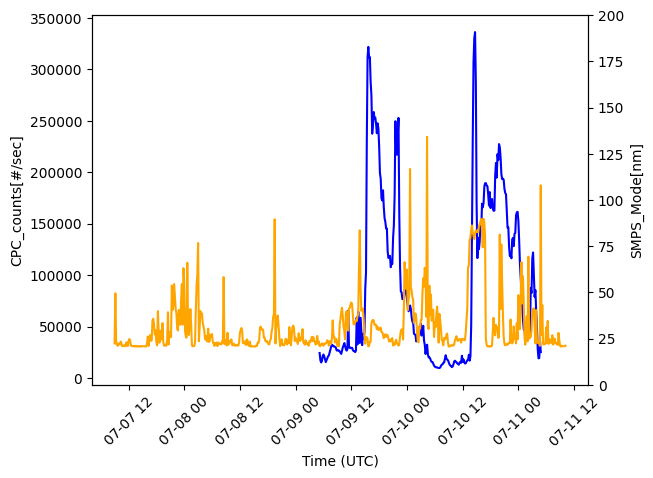

In [20]:
# Extract datetime and CPC data from the averaged lake
cpc_time = lake_averaged['cpc'].datetime64
cpc_data = lake_averaged['cpc']['CPC_count[#/sec]']

# Extract datetime and SMPS data from the averaged lake
smps_time = lake_averaged['smps_1d'].datetime64
smps_data = lake_averaged['smps_1d']['Mode_(nm)']

# Create a plot with two y-axes (twinx) for CPC and SMPS data
fig, ax = plt.subplots()
ax.plot(cpc_time,
        cpc_data,
        label='CPC',
        color='blue')
plt.xticks(rotation=45)

# Create a twinx axis for SMPS data
axb = ax.twinx()
axb.plot(smps_time,
         smps_data,
         label='SMPS',
         color='orange',)
axb.set_ylim(0, 200)

# Set labels for both y-axes and the x-axis
ax.set_xlabel("Time (UTC)")
ax.set_ylabel('CPC_counts[#/sec]')
axb.set_ylabel('SMPS_Mode[nm]')

# Show the plot and adjust layout for better presentation
plt.show()
fig.tight_layout()

# Summary

In this part of the tutorial, we learned how to work with multiple streams of data and load them into a `Lake` object, which is a collection of streams. We explored operations on the data, including averaging it over time using the `particula.data.lake_stats` module. This allowed us to create more meaningful visualizations by comparing the averaged and non-averaged data. The example demonstrated the power of the `particula.data` package in handling and analyzing scientific data efficiently.


In [21]:
help(Lake)

Help on class Lake in module particula.data.lake:

class Lake(builtins.object)
 |  Lake(streams: Dict[str, particula.data.stream.Stream] = <factory>) -> None
 |  
 |  A class representing a lake which is a collection of streams.
 |  
 |  Attributes:
 |      streams (Dict[str, Stream]): A dictionary to hold streams with their
 |      names as keys.
 |  
 |  Methods defined here:
 |  
 |  __delitem__(self, key: str) -> None
 |      Remove a stream by name.
 |      Example: del lake['stream_name']
 |  
 |  __dir__(self) -> list
 |      List available streams.
 |      Example: dir(lake)
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  __getattr__(self, name: str) -> Any
 |      Allow accessing streams as an attributes.
 |      Raises:
 |          AttributeError: If the stream name is not in the lake.
 |      Example: lake.stream_name
 |  
 |  __getitem__(self, key: str) -> Any
 |      Get a stream by name.
 |      Example: lake['stream_name']
 |  
 |  __init__(self, stream